In [1]:
# !pip install split-folders

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import optuna                  #bibliotecas para otimização
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.models import Sequential


from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import normalize, to_categorical
from keras.layers import Dropout
from keras.optimizers import SGD, RMSprop

import splitfolders  #separar treino, test e validacao

In [3]:

input_folder = "preprocessamento"   # nome da pasta onde estão as 3 classes
output_folder = "dataset_separado_semopt"  

splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=1337,
    ratio=(0.8, 0.05, 0.15),  # treino, validação, teste
)


Copying files: 1322 files [01:19, 16.67 files/s]


In [4]:
train_dir = "dataset_separado_semopt/train"
val_dir   = "dataset_separado_semopt/val"
test_dir  = "dataset_separado_semopt/test"

img_size = (128,128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="int",
    image_size=img_size,
    batch_size=batch_size,
    seed=710
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="int",
    image_size=img_size,
    batch_size=batch_size,
    seed=7200
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="int",
    image_size=img_size,
    batch_size=batch_size,
    seed=710
)


# Mostrar classes detectadas
class_names = train_ds.class_names
print("Classes detectadas:", class_names)

# "X" e "y" equivalentes
X_train, y_train = [], []
for batch_x, batch_y in train_ds:
    X_train.append(batch_x)
    y_train.append(batch_y)

X_test, y_test = [], []
for batch_x, batch_y in test_ds:
    X_test.append(batch_x)
    y_test.append(batch_y)

# Converter listas para tensores grandes (opcional)
X_train = tf.concat(X_train, axis=0)
y_train = tf.concat(y_train, axis=0)
X_test  = tf.concat(X_test, axis=0)
y_test  = tf.concat(y_test, axis=0)

print("The size of training dataset X is:", X_train.shape)
print("The size of testing dataset X is:", X_test.shape)

print("The size of training dataset y is:", y_train.shape)
print("The size of testing dataset y is:", y_test.shape)


Found 1057 files belonging to 3 classes.
Found 64 files belonging to 3 classes.
Found 201 files belonging to 3 classes.
Classes detectadas: ['Healthy_preprocessada', 'Powdery_preprocessada', 'Rust_preprocessada']
The size of training dataset X is: (1057, 128, 128, 3)
The size of testing dataset X is: (201, 128, 128, 3)
The size of training dataset y is: (1057,)
The size of testing dataset y is: (201,)


In [5]:
X_train = X_train.numpy()
X_test = X_test.numpy()

X_train = (X_train.astype('float32')) / 255.
X_test = (X_test.astype('float32')) / 255.


In [6]:
num_classes = 3
kernel_initializer = 'he_uniform'    #Also try 'zeros', 'random_uniform', 'he_uniform', 'glorot_uniform'
drop = 0.25

model1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(128,128,3)),    #normalização para float de forma diferente por serem tensores

    # Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=kernel_initializer),  # 1arg: número de filtros; 2 arg: tamanho da janela (menor para mais detalhes);
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=kernel_initializer),
    MaxPooling2D((2,2)),
    Dropout(drop),

    # Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=kernel_initializer),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=kernel_initializer),
    MaxPooling2D((2,2)),
    Dropout(drop),

    Flatten(),
    Dense(512, activation='relu', kernel_initializer=kernel_initializer),
    # Dropout(drop),
    Dense(num_classes, activation='softmax')  # 3 classes
])

opt = SGD(learning_rate=0.001, momentum=0.9)

model1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model1.summary()


c:\Users\lorena24014\.conda\envs\img_proc\lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,575,875 (128.08 MB)

 Trainable params: 33,575,875 (128.08 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.3349 - loss: 1.0988 - val_accuracy: 0.3483 - val_loss: 1.0976
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.3557 - loss: 1.0980 - val_accuracy: 0.4677 - val_loss: 1.0970
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.3557 - loss: 1.0973 - val_accuracy: 0.3532 - val_loss: 1.0961
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.3614 - loss: 1.0965 - val_accuracy: 0.4826 - val_loss: 1.0954
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.4588 - loss: 1.0956 - val_accuracy: 0.4478 - val_loss: 1.0945
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.3510 - loss: 1.0944 - val_accuracy: 0.3483 - val_loss: 1.0932
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.4011 - loss: 1.0939 - val_accuracy: 0.4179 - val_loss: 1.0924
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.4087 - loss: 1.0939 - val_accuracy: 0

In [8]:
_, acc = model1.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6667 - loss: 0.9465
Accuracy =  66.66666865348816 %


In [ ]:
#predições a partir do modelo de teste
y_pred_prob = model1.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

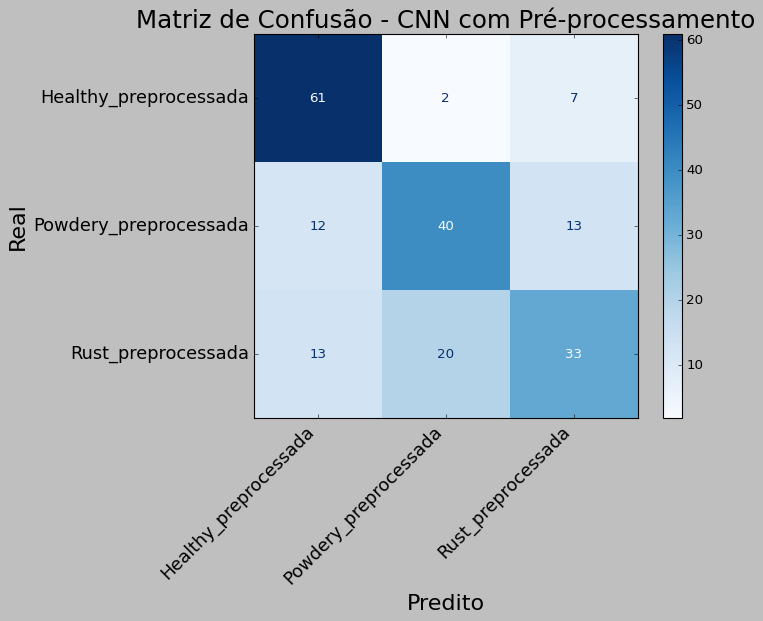

In [26]:
matriz_confusao = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusao,
    display_labels=class_names
)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)

# 🔹 Aumentar fonte dos ticks (labels nos eixos)
ax.tick_params(axis='both', labelsize=16)

# 🔹 Rotacionar labels do eixo X
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# 🔹 Aumentar fonte dos labels dos eixos
ax.set_xlabel("Predito", fontsize=20)
ax.set_ylabel("Real", fontsize=20)

# 🔹 Aumentar fonte do título
plt.title("Matriz de Confusão - CNN com Pré-processamento", fontsize=22)

plt.show()
